<a href="https://colab.research.google.com/github/gackouhamady/MLSD-25-26-Courses/blob/main/01-Data-Engineering/BI/notebooks/04_Statistical_Experiments_and_Significance_testing_R.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Statistical Experiments and Significance Testing**



In [ ]:
if (!require(dplyr)) install.packages('dplyr')
if (!require(ggplot2)) install.packages('ggplot2')
if (!require(lmPerm)) install.packages('lmPerm')
if (!require(pwr)) install.packages('pwr')

Loading required package: dplyr


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: ggplot2

Loading required package: lmPerm

Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
“there is no package called ‘lmPerm’”
Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Loading required package: pwr

Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
“there is no package called ‘pwr’”
Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [ ]:
library(ggplot2)
library(dplyr)
library(lmPerm)
library(pwr)

# Resampling

$\underline{Two~~main~~types}$ :
- the bootstrap test (to assess the reliability of an estimate)
- the permutation test (to test hypothesis involving two or more groups)

$\underline{Permutation~test}$:
- Combining two or more samples together and randomly reallocating the observations to resamples.
- The null hypothesis is that the treatments to which the groups were exposed do not differ.

$\underline{Permutation~~procedure}$
- **Combine** the results from the different groups into a single data set.
- **Shuffle** the combined data and then randomly draw (without replacement) a resample of the same size as group A.
- From the remaining data, **randomly draw** (without replacement) a resample of the same size as group B.
- Do the same for groups C, D and so on. You have now collected one set of resamples that **mirror the sizes** of the original samples.
- Whatever statistic or estimate was calculated for the original samples (e.g. difference in group proportions), calculate it now for the resamples, and record; this constitutes **one permutation iteration**.
- Repeat the previous step ***R* times** to yield a permutation **distribution of the test statistic** (i.e. th metric used to measure the effect of a treatment)
- **If the observed difference lies outside most of the permutation distribution, then we conclude that chance is not responsible.**


## Example: Web stickiness

A company wants to test which of two web presentations does a better selling job. The company decides to measure the results with a proxy variable, which is the average session time. It is reasonnable to think that a web page that holds people's attentionlonger will lead to more sales. <br>

Data are as follows: 36 average session times for the two different presentations; 21 for page A and 15 for page B.

In [ ]:
# Load the data
session_times <- read.csv(file.path('sample_data', 'web_page_data.csv'))
session_times[,2] <- session_times[,2] * 100

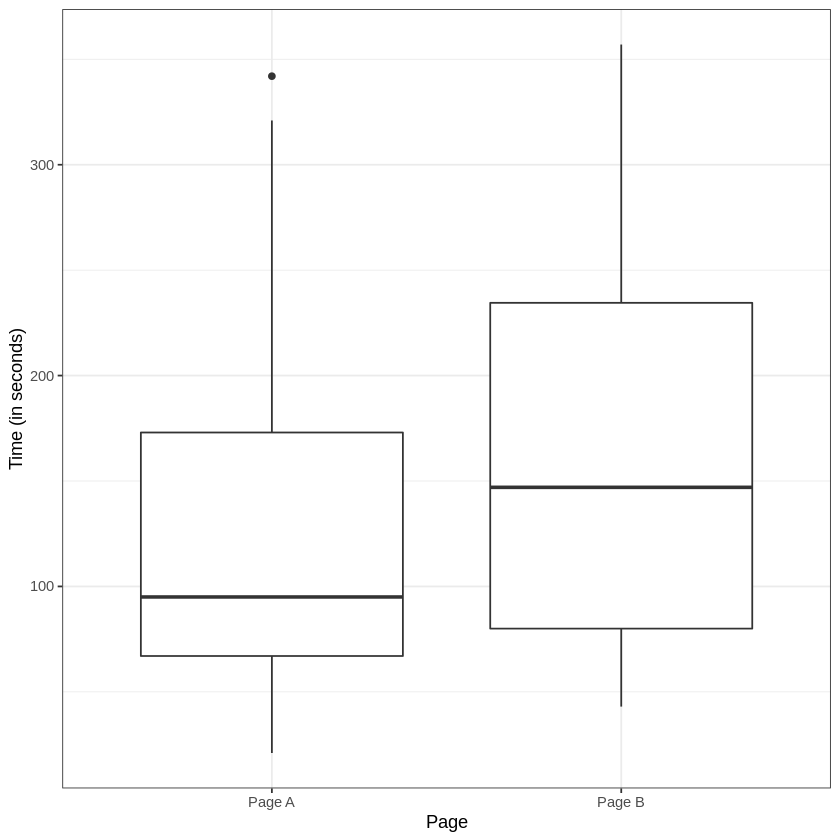

In [ ]:
# Plot the data distribution for the two groups
graph <- ggplot(session_times, aes(x=Page, y=Time)) +
  geom_boxplot() +
  labs(y='Time (in seconds)') +
  theme_bw()
graph

# Page B leads to longer sessions than page A.

In [ ]:
mean_a <- mean(session_times[session_times['Page'] == 'Page A', 'Time'])
mean_b <- mean(session_times[session_times['Page'] == 'Page B', 'Time'])
mean_b - mean_a

# Page B has session time that are greater than those of page A by 35,67
# seconds on average. Is it statistically significant?

[1] 35.66667

In [ ]:
# Apply a permutation test to found out
perm_fun <- function(x, nA, nB)
{
  n <- nA + nB
  idx_b <- sample(1:n, nB)  # sampling without replacement
  idx_a <- setdiff(1:n, idx_b)
  mean_diff <- mean(x[idx_b]) - mean(x[idx_a])
  return(mean_diff)
}

[1] 0.141

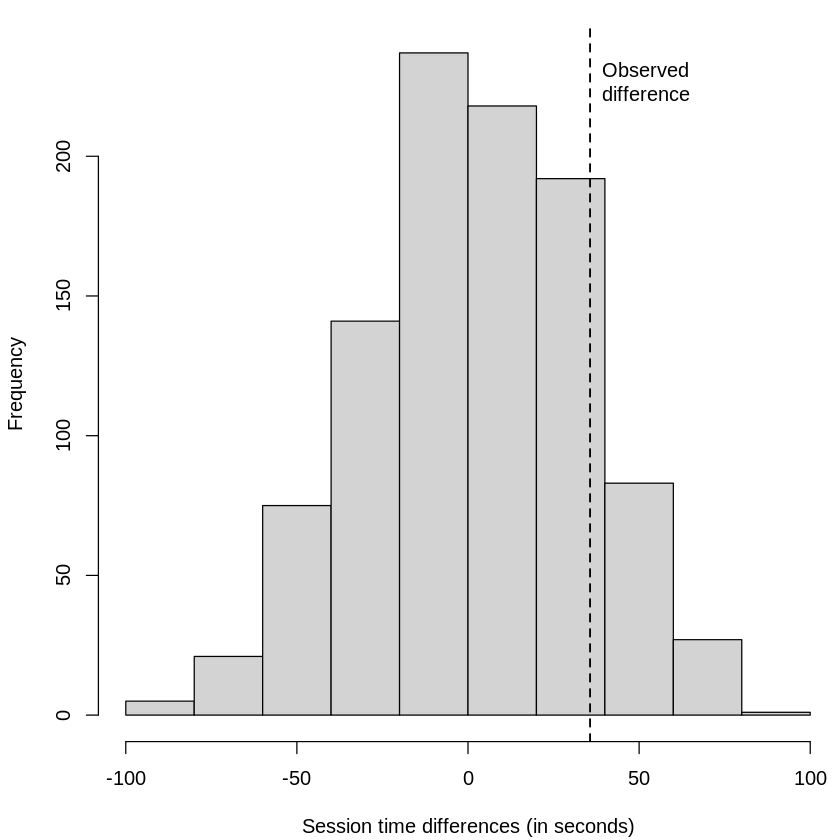

In [ ]:
# We permute 1000 and observe the distribution of the mean difference between A and B
set.seed(1)
perm_diffs <- rep(0, 1000)
for (i in 1:1000) {
  perm_diffs[i] = perm_fun(session_times[, 'Time'], 21, 15)
}
par(mar=c(4,4,1,0)+.1)
hist(perm_diffs, xlab='Session time differences (in seconds)', main='')
abline(v=mean_b - mean_a, lty=2, lwd=1.5)
text('  Observed\n  difference', x=mean_b - mean_a,  y=par()$usr[4]-20, adj=0)

# NB:
# The mean difference of random permutations often exceeds the observed difference
# in session times.

# Percentage of cases where this happens (right part of the vertical dashed line)
mean(perm_diffs > (mean_b - mean_a))

# NB:
# This suggest that the observed difference in session between page 1 and page B
# is well within the range of chance variation and thus is not statistically
# significant.

# Statistical Significance and P-Values

We want to measure if a result is more extreme than what chance might produce.
If yes, it is said to be **satistically significant**.

$\underline{p-value}$ : Given a chance model that embodies the null hypothesis, the p-value is the probability of obtaining results as unusual or extreme as the observed results.

$\underline{\alpha}$ : The probability threshold of 'unusualness' that chance results must surpass for actual outcomes to be deemed statistically significant.

$\underline{Type~~1~~error}$ : Mistakenly concluding an effect is real when it is due to chance (False Positive)

$\underline{Type~~2~~error}$ : Mistakenly concluding an effect is due to chance when it is real (False Negative)


**Example: eCommerce**

Let us suppose that we have two article, A & B. The company selling these articles has cumulated the following data:
- out of $23,739$ purchases, the article A was returned $200$ times
- out of $22,588$ purchases, the article B was returned $182$ times

We can test whether the difference in the returns frequency between article A and article B is within the range of chance variation using a resampling procedure.

$\underline{Question}$ : *If the two articles share the same return rate, could chance variation produce a difference as big as $5\%$?*

$\underline{Procedure}$<br>
1. Consider a samples set with $(200+182)=382$ returns (class $1$) and $(23,539+22,406)=45,945$ non returns (class $0$). The rate is $\frac{382}{45,945})$.<br>
2. We shuffle and draw out a resample of size $23,739$ (same $n$ as article A), and record how many $1s$.<br>
3. Record the number of $1s$ in the remaining $22,588$ (same $n$ as article B).<br>
4. Record the difference in proportion of $1s$.<br>
5. Repeat steps 2--4.<br>
6. How often was the difference $\geq 100 \times (\frac{200}{23,739} - \frac{182}{22,588})=0,0368$?

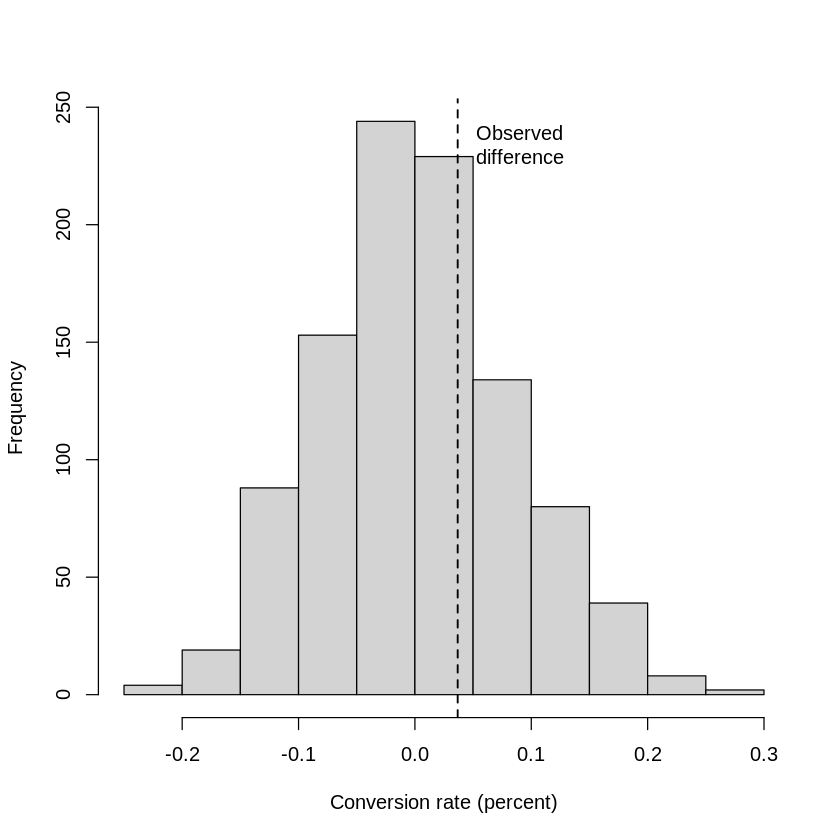

In [ ]:
obs_pct_diff <- 100 * (200 / 23739 - 182 / 22588)
conversion <- c(rep(0, 45945), rep(1, 382))
perm_diffs <- rep(0, 1000)
for (i in 1:1000) {
  perm_diffs[i] = 100 * perm_fun(conversion, 23739, 22588)
}

hist(perm_diffs, xlab='Conversion rate (percent)', main='')
abline(v=obs_pct_diff, lty=2, lwd=1.5)
text('   Observed\n   difference', x=obs_pct_diff,  y=par()$usr[4]-20, adj=0)

# NB:
# The observed difference of $0,0368\%$ is well within the range of chance variation.

In [ ]:
# p-value:
# The frequency with which the chance model produces a results more
# extreme than the observed result.
#
# p-value from permutation test:
# Take the proportion of times that the permutation test produces a difference
# equal to or greater than the observed difference.
#
# "Given a chance model, what is the probability that this happened by chance?"

In [ ]:
mean(perm_diffs > obs_pct_diff)

# Meaning: We would expect to achieve a result as extreme as this obs_pct_diff,
# or more extreme than this, by random chance $34\%$ of time.

[1] 0.34

For this eCommerce example, we don't need to use a permutation test to get a p-value. With a binomial distribution, we can approximate the p-value.

In [ ]:
prop.test(x=c(200,182), n=c(23739,22588), alternative='greater')

# x = number of successes for each group
# n = number of trials
#
# The normal approximation yields a p-value of $0.3498$, which is close to
# the p-value obtained from the permutation test.


	2-sample test for equality of proportions with continuity correction

data:  c(200, 182) out of c(23739, 22588)
X-squared = 0.14893, df = 1, p-value = 0.3498
alternative hypothesis: greater
95 percent confidence interval:
 -0.001057439  1.000000000
sample estimates:
     prop 1      prop 2 
0.008424955 0.008057376 


# t-Tests

This significance test is named after Student's t-distribution, originally developed by W.S. Gosset to approximate the distribution of a sample mean.<br>

The t-test is a good approximation to the permutation (shuffled) distribution. Ii is used for the very common A/B test (two-sample comparison) in which the data is numeric. A standardized form of the statistic test must be used.

In [ ]:
t.test(Time ~ Page, data=session_times, alternative='less')

# NB:
# Alternative hypothesis = the session time mean for page A is less than that
# for page B. The p-value of 0.1408 is very similar to the permutation test p-value.


	Welch Two Sample t-test

data:  Time by Page
t = -1.0983, df = 27.693, p-value = 0.1408
alternative hypothesis: true difference in means between group Page A and group Page B is less than 0
95 percent confidence interval:
     -Inf 19.59674
sample estimates:
mean in group Page A mean in group Page B 
            126.3333             162.0000 


# Multiple Testing: ANOVA

Suppose that we have a comparison of multiple groups A/B/C/D, each with numeric data. The statistical procedure that tests for a statistically significant difference among the groups is called *analysis of variance*, or *ANOVA*.

### Example: Stickiness of four web pages

The *stickiness* is the number of seconds a visitor spent on the page. There are 5 visitors for each page. There are 6 possible comparisons between groups:
- Page 1 compared to page 2
- Page 1 compared to page 3
- Page 1 compared to page 4
- Page 2 compared to page 3
- Page 2 compared to page 4
- Page 3 compared to page 4

The more tests you do, the greater the potential for being fooled by random chance... Can we do an overall test that addresses the following question:<br>

*'Could all pages have the same underlying stickiness, and the differences among them be due to the random way in which a common set of session times got allocated among the four pages?'*

**The ANOVA permutation procedure for the stickiness example**

1. Combine all the data together in a single box.<br>
2. Shuffle and draw out four resamples of five values each.<br>
3. Record the mean of each of the four groups.<br>
4. Record the variance among the four group means.<br>
5. Repeat steps 2-4 many times (say, $1,000$).

$\underline{p-value}$ : the proportion of the time the resampled variance exceed the observed variance.<br>

You can use the ${\tt aovp}$ function in the R package ${\tt lmPerm}$.

In [ ]:
# Load the new data set
four_sessions  <- read.csv(file.path('sample_data', 'four_sessions.csv'))
head(four_sessions)

,Page,Time
,<chr>,<int>
1,Page 1,164
2,Page 2,178
3,Page 3,175
4,Page 4,155
5,Page 1,172
6,Page 2,191


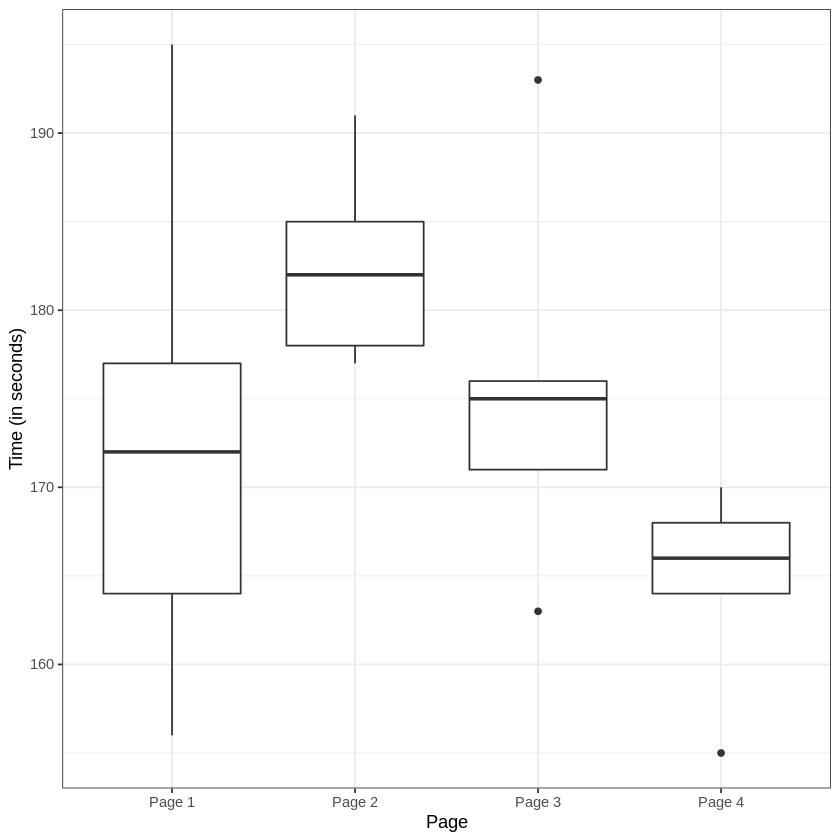

In [ ]:
# Plot the data
graph <- ggplot(four_sessions, aes(x=Page, y=Time)) +
  geom_boxplot() +
  labs(y='Time (in seconds)') +
  theme_bw()
graph

In [ ]:
summary(aovp(Time ~ Page, data = four_sessions))

# NB:
# The p-value is given by Pr(Prob) (for me: 0.07947): given the underlying stickiness,
# 7.9% of the time the response rate among four pages might differ as much as was
# actually observed, just by chance.
#
# Pr(Prob) > 0.05 ==> the difference among the four pages could have arisen by chance

[1] "Settings:  unique SS "


Component 1 :
            Df R Sum Sq R Mean Sq Iter Pr(Prob)  
Page1        3    831.4    277.13 5000   0.0772 .
Residuals   16   1618.4    101.15                
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


**The ANOVA statistical test for the stickiness example**

Just like t-test can be used instead of a permutation test for comparing the mean of the two groups, there is a statistical test for ANOVA based on the *F-statistic*.

The *F-statistic* is based on the ratio of the variance across group means (e.g.treatment effect) to the variance due to residual error. The higher this ratio, the more statistically significant the result.

You can use the ${\tt aov}$ function in the R package ${\tt lmPerm}$.

In [ ]:
summary(aov(Time ~ Page, data=four_sessions))

# NB:
# The F-statistic is MS(treatment)/MS(error). The F value can be compare to a
# F-distribution to determine whether the differences among treatment means are
# greater than would be expected in random chance variation.
#
# Here, Pr(>F) > 0.05 ==> the difference among the four pages could have arisen by chance

            Df Sum Sq Mean Sq F value Pr(>F)  
Page         3  831.4   277.1    2.74 0.0776 .
Residuals   16 1618.4   101.2                 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

# Chi-square test

The chi-square test is used with count data to test how well it fits some expected distribution. It assesses whether the null hypothesis of independence among variables is reasonnable.

$\underline{Chi-square~statistic}$ A measure of the extent to which some observed data departs from expectation.

**Chi-square test: a resampling approach**

We want to test three headlines -- A, B and C -- that were run each on $1,000$ visitors. The counts are given in the table below. It appears that Headline A returns nearly twice that click rate of B. The number are small. A resampling approach can test whether the click rates differ to an extent greater than chance might cause.
<br><br>

<table>
    <tr>
        <td>
...
        </td>
        <td>
$\mathbf{Headline A}$
        </td>
        <td>
$\mathbf{Headline B}$
        </td>
        <td>
$\mathbf{Headline C}$
        </td>
    </tr>
    <tr>
        <td>
$\mathbf{Click}$
        </td>
        <td>
14
        </td>
        <td>
8
        </td>
        <td>
12
        </td>
    </tr>
    <tr>
        <td>
$\mathbf{No-Click}$
        </td>
        <td>
986
        </td>
        <td>
992
        </td>
        <td>
988
        </td>
    </tr>
</table>
<br><br>

The next table present the 'expected' distribution of clicks which embed the null hypothesis assumption that all three headlines share the same click rate, for an overall click rate of $\frac{34}{3,000}$.
<br><br>

<table>
    <tr>
        <td>
...
        </td>
        <td>
$\mathbf{Headline A}$
        </td>
        <td>
$\mathbf{Headline B}$
        </td>
        <td>
$\mathbf{Headline C}$
        </td>
    </tr>
    <tr>
        <td>
$\mathbf{Click}$
        </td>
        <td>
11.33
        </td>
        <td>
11.33
        </td>
        <td>
11.33
        </td>
    </tr>
    <tr>
        <td>
$\mathbf{No-Click}$
        </td>
        <td>
988.67
        </td>
        <td>
988.67
        </td>
        <td>
988.67
        </td>
    </tr>
</table>
<br><br>

The *Pearson residual*, $R$, measures the extent to which the actual counts differ from these expected counts (see table below). $R$ is defined as:
$R = \frac{Observed-Expected}{\sqrt{Expected}}$
<br><br>

<table>
    <tr>
        <td>
...
        </td>
        <td>
$\mathbf{Headline A}$
        </td>
        <td>
$\mathbf{Headline B}$
        </td>
        <td>
$\mathbf{Headline C}$
        </td>
    </tr>
    <tr>
        <td>
$\mathbf{Click}$
        </td>
        <td>
0.792
        </td>
        <td>
-0.990
        </td>
        <td>
0.198
        </td>
    </tr>
    <tr>
        <td>
$\mathbf{No-Click}$
        </td>
        <td>
-0.085
        </td>
        <td>
0.106
        </td>
        <td>
-0.021
        </td>
    </tr>
</table>
<br><br>

The **chi-square statistic** is defined as the sum of the squared Pearson residuals:
$X = \sum\limits_i^r\sum\limits_j^c R^2$
with $r$ and $c$ the number of rows and columns. In our example, $X=1.666$. Is that more than could reasonably occur in a chance model?

**$\underline{Chi-square~resampling~procedure}$**

We can test with this resampling algorithm:
1. Constitute a box with 34 ones and 2,966 zeros.<br>
2. Shuffle, take three separate samples of $1,000$ and count the clicks in each.<br>
3. Find the squared differences between the shuffled counts and the expected counts and sum them.<br>
4. Repeat steps 2 and 3, $1,000$ times.<br>
5. How often does the resampled sum of squared deviations exceed the observed? **That's the p-value.**

In [ ]:
# The function chisq.test can be used to compute a resample chi-square statistic
click_rate <-  read.csv(file.path('sample_data', 'click_rates.csv'))
clicks <- matrix(click_rate$Rate, nrow=3, ncol=2, byrow=TRUE)
dimnames(clicks) <- list(unique(click_rate$Headline), unique(click_rate$Click))
print(clicks)

chisq.test(clicks, simulate.p.value=TRUE)

# NB:
# The obtained p-value shows that this result could easily have been obtained
# by randomness.

           Click No-click
Headline A    14      986
Headline B     8      992
Headline C    12      988



	Pearson's Chi-squared test with simulated p-value (based on 2000
	replicates)

data:  clicks
X-squared = 1.6659, df = NA, p-value = 0.4793


**$\underline{Chi-square~statistical~theory}$**

The distributionof the chi-square statistic can be approximated by a *chi-square distribution*. The appropriate standard chi-square distribution is determined by the *degree of freedom*. For a contingency table, it is given by $(r-1)(c-1)$.

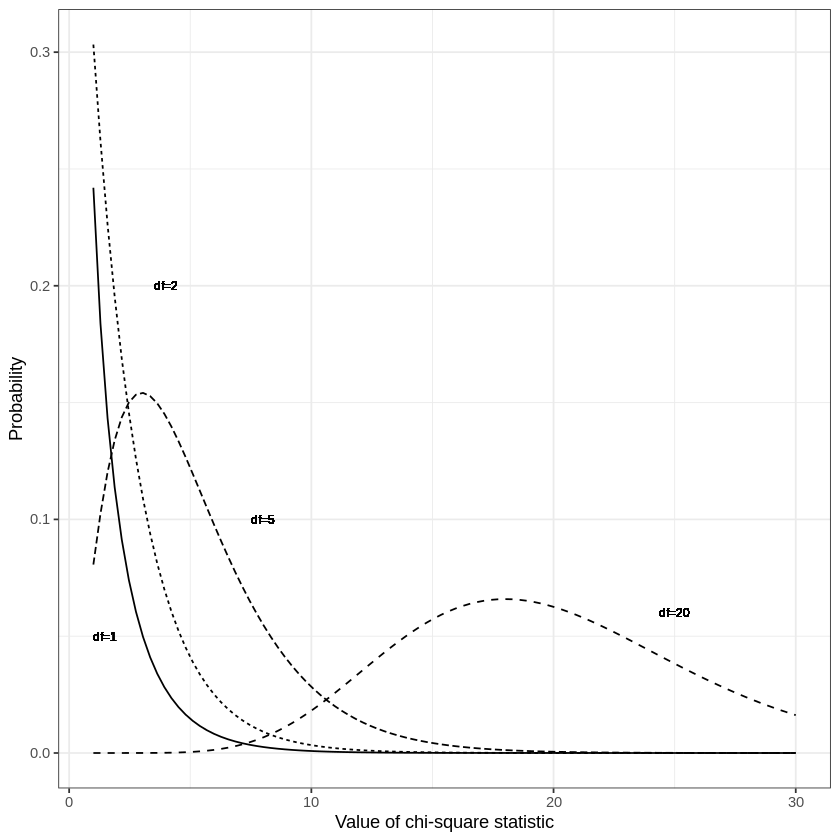

In [ ]:
x <- seq(1, 30, length=100)
chi <- data.frame(df = factor(rep(c(1, 2, 5, 20), rep(100, 4))),
                  x = rep(x, 4),
                  p = c(dchisq(x, 1), dchisq(x, 2), dchisq(x, 5), dchisq(x, 20)))

graph <- ggplot(chi, aes(x=x, y=p)) +
  geom_line(aes(linetype=df)) +
  geom_text(aes(x=25, y=0.06, label='df=20'), size=2.5) +
  geom_text(aes(x=8, y=0.1, label='df=5'), size=2.5) +
  geom_text(aes(x=4, y=0.2, label='df=2'), size=2.5) +
  geom_text(aes(x=1.5, y=0.05, label='df=1'), size=2.5) +
  theme_bw() + theme(legend.position = "none") +
  labs(x='Value of chi-square statistic', y='Probability')
graph

# NB:
# The further out on the chi-square distribution the observed statistic is, the
# lower the p-value.

In [ ]:
# The function chisq.test can be used tom compute the p-value using the
# chi-square distributionas a reference
chisq.test(clicks, simulate.p.value = FALSE)


	Pearson's Chi-squared test

data:  clicks
X-squared = 1.6659, df = 2, p-value = 0.4348


# Fisher's exact test

The chi-square distribution is a good approximation of the suffled resampling test, **expect when counts are extremely low**. Yet, most statistical software has a procedure to actually enumerate *all* the possible rearrangements (permutations) that can occur, tabulate their frequencies, and determine exactly how extreme the observed results is. This is called *Fisher's exact test*.

In [ ]:
fisher.test(clicks)

# NB:
# The p-value is very close to the p-value of 0.4853 obtained using the resampling method.


	Fisher's Exact Test for Count Data

data:  clicks
p-value = 0.4824
alternative hypothesis: two.sided


# Multi-Arm Bandit Algorithm

This method offer an approach to testing, especially web testing, and allows you to testmultiple treatments at once. It reaches conclusions faster than traditional statistical designs.

$\underline{One-armed~bandit}$ : slot machines used in gambling that is configured in such a way that they extract money from the gambler in a steady flow.

$\underline{Multi-armed~bandit}$ : Imagine a slot machine with more than one arm, each arm paying out at a different rate...

**Your goal**: to win as much money as possible and, more specifically, to identify and settle on the winning arm sooner rather than later. But, you don't know at what overall rate the arms pay out and you only have the results of individual pulls on the arms.

**Intuitive approach**: Let's suppose you have three arms, A/B/C and that A *looks like* it is the winner. We start pulling A more often, but we don't abndon B and C. We just pull them less often. If A continues to be the winner, we pull less B and C, and more A. But, if C starts to be the winner, we favor C, and pull less B and C. We repeat this until an overall winner emerge.



**$ϵ$-greedy algorithm for an A/B test:**

We want to apply the multi-armed bandit approach to web testing.You have multiple offers, headline, colors, and so on being tested on a website. Customers either **click** (ie **win** for the merchant) or don't click. Initially, the offers are shown randomly and equally. If, however, one offer starts to outperform the others, it can be **shown** (ie. **pulled**) more often.

1. Generate a uniformly distributed random number between 0 and 1.
2. If the number lies between 0 and $ϵ$ (where $ϵ$ is a number between 0 and 1, typically fairly small), flip a fair coin (50/50 probability), and:
  a. If the coin is heads, show offer A.<br>
  b. If the coin is tails, show offer B.<br>
3. If the number is $\geq ϵ$, show whichever offer has had the highest response rate to date.

$(\epsilon = 1) ⇒$ standard simple A/B experiment<br>
$(\epsilon = 0) ⇒$ standard greedy A/B experiment<br>

Bandit algorithms can efficiently handle more than 3 treatments and mode toward optimal selection of the 'best'.